# MuVIcell Tutorial: Multi-View Integration for Sample-Aggregated Single-Cell Data

This notebook demonstrates how to use the MuVIcell package for multi-view integration and analysis of sample-aggregated single-cell data using MuVI (Multi-View Integration).

## Overview

MuVIcell provides a streamlined workflow for:
1. **Generating/Loading** multi-view data in muon format (samples x features)
2. **Preprocessing** data for MuVI analysis
3. **Running MuVI** to identify latent factors using `muvi.tl.from_mdata`
4. **Analyzing** and interpreting factors
5. **Visualizing** results

Note: Each row represents a **sample** (not individual cells) and views contain **cell type aggregated data per sample**.

In [1]:
import muvicell
muvicell.__version__

'0.1.2'

In [2]:
import tensordict
tensordict.__version__

'0.7.2'

In [3]:
import numpy as np
import pandas as pd
import muon as mu
import warnings
warnings.filterwarnings('ignore')

from plotnine import *
import scanpy as sc

# Import muvicell modules
from muvicell import synthetic, preprocessing
from muvicell.analysis import *
from muvicell.visualization import *

# Import MuVI directly to show compatibility
import muvi

np.random.seed(0)

In [4]:
device = "cpu"
try:
    device = f"cuda:{muvi.get_free_gpu_idx()}"
except Exception as e:
    print(e)

Torch not compiled with CUDA enabled


## 1. Generate Synthetic Multi-View Data

Generate synthetic data with 3 views (5, 10, 15 features) and 200 samples:

In [5]:
# Generate synthetic multi-view data (3 views matching 3 true factors)
mdata = synthetic.generate_synthetic_data(
    n_samples=200,
    view_configs={
        'Cell Type 1': {'n_vars': 5, 'sparsity': 0.15},
        'Cell Type 2': {'n_vars': 10, 'sparsity': 0.25},
        'Cell Type 3': {'n_vars': 15, 'sparsity': 0.35}
    },
    random_state=0
)

print(f"Generated synthetic data:")
print(f"- Samples: {mdata.n_obs}")
print(f"- Views: {len(mdata.mod)} ({', '.join([f'{k}: {v.n_vars} features' for k, v in mdata.mod.items()])})")
print(f"- Total features: {sum(v.n_vars for v in mdata.mod.values())}")

Generated synthetic data:
- Samples: 200
- Views: 3 (Cell Type 1: 5 features, Cell Type 2: 10 features, Cell Type 3: 15 features)
- Total features: 30


## 2. Add Latent Factor Structure

Add realistic latent factor structure to the synthetic data:

In [6]:
# Add latent structure with 3 factors (matching n_true_factors)
mdata_structured = synthetic.add_latent_structure(
    mdata, 
    n_latent_factors = 3,
    factor_variance = [0.5, 0.4, 0.3],
    structure_strength = 1.0,
    baseline_strength = 0.6
)

print(f"Sample metadata columns: {list(mdata_structured.obs.columns)}")

Sample metadata columns: ['Cell Type 1:sample_id', 'Cell Type 1:batch', 'Cell Type 1:total_counts', 'Cell Type 2:sample_id', 'Cell Type 2:batch', 'Cell Type 2:total_counts', 'Cell Type 3:sample_id', 'Cell Type 3:batch', 'Cell Type 3:total_counts', 'sim_factor_1', 'sim_factor_2', 'sim_factor_3', 'batch']


### Visualize the synthetic data

In [7]:
for mod in mdata_structured.mod:
    # Highly variable features can be used if there's enough of them
    sc.pp.pca(mdata_structured[mod], 
              use_highly_variable=False)
    sc.pp.neighbors(mdata_structured[mod])

mu.pp.neighbors(mdata_structured)

... storing 'batch' as categorical


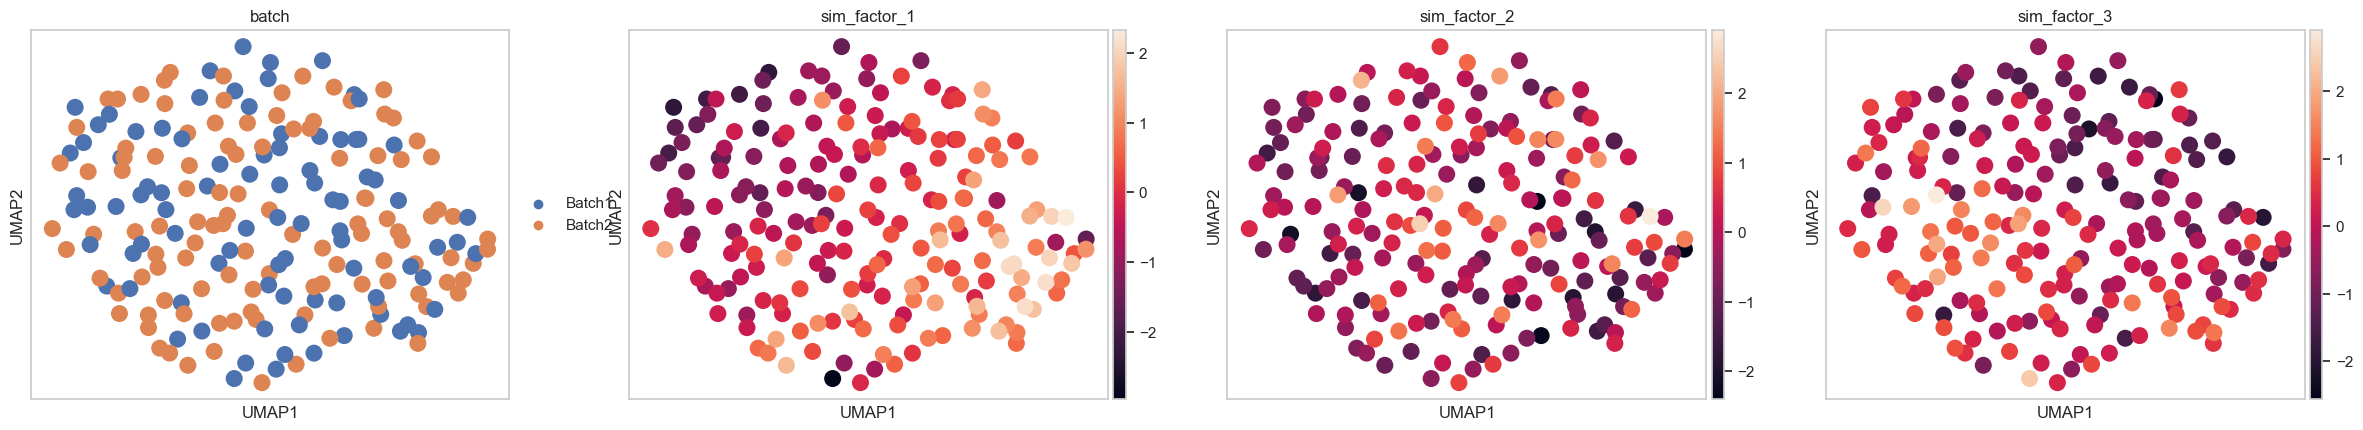

In [8]:
# Copy factor loadings to single view
for var in ['sim_factor_1', 'sim_factor_2', 'sim_factor_3']:
    mdata_structured[mod].obs[var] = mdata_structured.obs[var]

sc.tl.umap(mdata_structured[mod], random_state=0)
sc.pl.umap(mdata_structured[mod], color=['batch', 
                                        'sim_factor_1',
                                        'sim_factor_2',
                                        'sim_factor_3'])

... storing 'Cell Type 1:batch' as categorical
... storing 'Cell Type 2:batch' as categorical
... storing 'Cell Type 3:batch' as categorical
... storing 'batch' as categorical


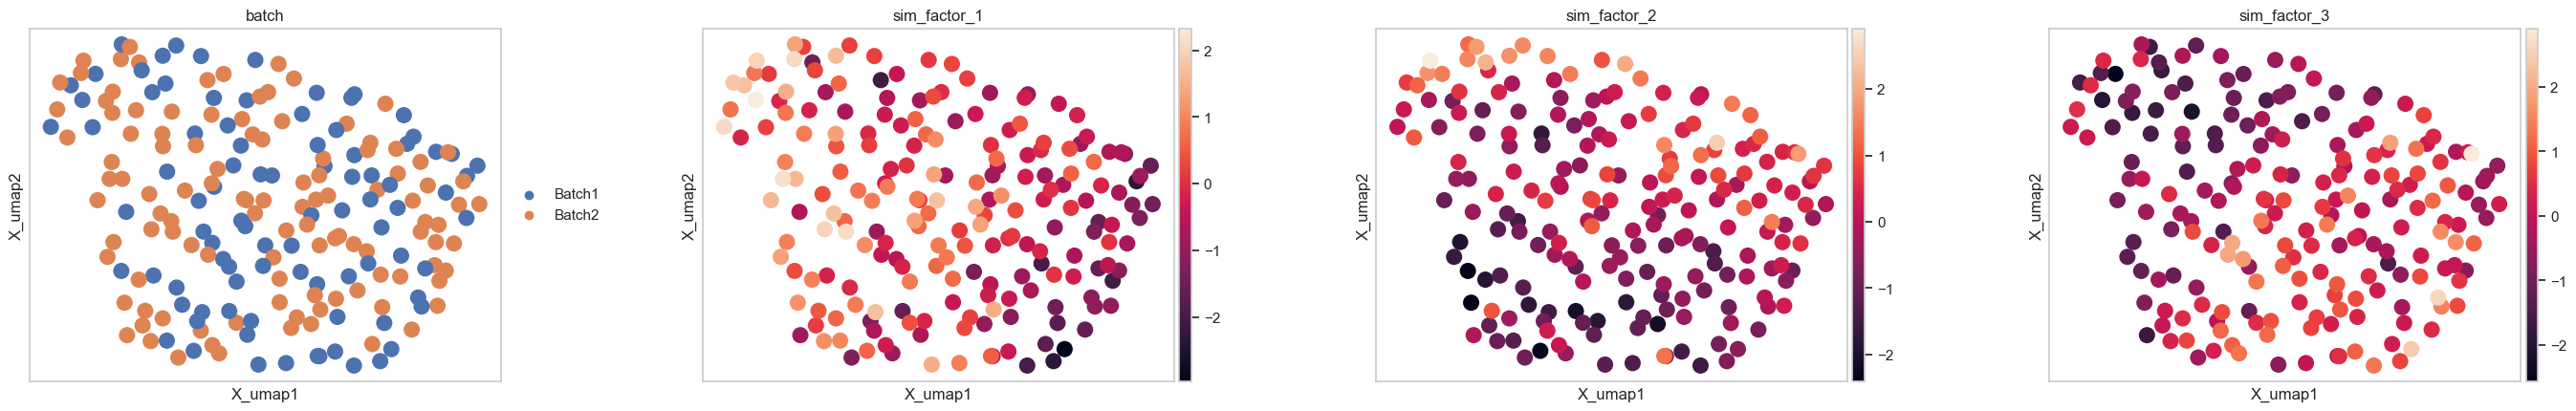

In [9]:
mu.tl.umap(mdata_structured, random_state=0)
mu.pl.umap(mdata_structured, wspace=0.3, color=['batch', 
                                                'sim_factor_1',
                                                'sim_factor_2',
                                                'sim_factor_3'])

With these parameters, we create 3 latent factors with specified variances, a strong structured signal, and a moderate baseline signal across all features.

In [10]:
# Let's say an exposure variable is highly correlated with factor 1
mdata_structured.obs['exposure'] = [np.random.choice(["Hi", "Medium", "Low"], p = [0.7,0.2,0.1]) if x > 1 else
                                    np.random.choice(["Hi", "Medium", "Low"], p = [0.1,0.7,0.2]) if x > 0 else
                                    np.random.choice(["Hi", "Medium", "Low"], p = [0.1,0.2,0.7]) 
                                    for x in mdata_structured.obs['sim_factor_1']]
mdata_structured.obs['exposure'] = pd.Categorical(mdata_structured.obs['exposure'], 
                                                  categories=["Low", "Medium", "Hi"], 
                                                  ordered=True)
mdata_structured.obs['exposure'].value_counts()

exposure
Low       89
Medium    73
Hi        38
Name: count, dtype: int64

## 3. Preprocess Data for MuVI

Apply preprocessing pipeline (optimized for synthetic data):

In [11]:
# Preprocess for MuVI analysis
mdata_processed = preprocessing.preprocess_for_muvi(
    mdata_structured,
    filter_cells=False,  # Don't filter synthetic data
    filter_genes=False,  # Don't filter synthetic data
    normalize=True,
    find_hvg=False,      # Skip HVG for synthetic data
    subset_hvg=False
)

print(f"Preprocessed data shape: {mdata_processed.shape}")
print("Data ready for MuVI analysis")

Modality name: Cell Type 1
Modality name: Cell Type 2
Modality name: Cell Type 3
Preprocessed data shape: (200, 30)
Data ready for MuVI analysis


## 4. Run MuVI Analysis

Run MuVI using the exact same API as the original analysis, with 3 factors to match our synthetic data:

In [12]:
# Run MuVI using the standard API
model = muvi.tl.from_mdata(
    mdata_processed,
    n_factors=3,
    nmf=False,
    device=device
)

# Fit the model
model.fit(seed=0)

print(f"MuVI model fitted with {model.n_factors} factors")

2025-09-23 18:24:20,910 - muvi.core.models - WARNING - No view names provided!
2025-09-23 18:24:20,911 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2025-09-23 18:24:20,912 - muvi.core.models - INFO - pd.DataFrame detected.
2025-09-23 18:24:20,913 - muvi.core.models - INFO - Storing the index of the view `Cell Type 1` as sample names.
2025-09-23 18:24:20,914 - muvi.core.models - INFO - pd.DataFrame detected.
2025-09-23 18:24:20,914 - muvi.core.models - INFO - pd.DataFrame detected.
2025-09-23 18:24:20,915 - muvi.core.models - INFO - pd.DataFrame detected.
2025-09-23 18:24:20,915 - muvi.core.models - INFO - pd.DataFrame detected.
2025-09-23 18:24:20,916 - muvi.core.models - INFO - pd.DataFrame detected.
2025-09-23 18:24:20,916 - muvi.core.models - INFO - Likelihoods set to `{'Cell Type 1': 'normal', 'Cell Type 2': 'normal', 'Cell Type 3': 'normal'}`.
2025-09-23 18:24:20,917 - muvi.core.models - INFO - NMF set to `{'Cell Type 1':

  0%|          | 0/10000 [00:00<?, ?it/s]

2025-09-23 18:24:20,946 - root - INFO - Guessed max_plate_nesting = 3


 10%|█         | 1011/10000 [00:09<01:24, 105.82it/s, ELBO=39] 

Relative improvement of -0.003072 < 1e-05 for 10 step(s) in a row, stopping early.
2025-09-23 18:24:30,494 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.
MuVI model fitted with 3 factors


In [13]:
# Display variance explained
r2_pool = []
for vn in model.get_factor_loadings().keys():
    rec = model.get_factor_scores() @ model.get_factor_loadings()[vn]
    r2 = pd.DataFrame({'x': mdata_processed[vn].X.flatten(), 
                       'y': rec.flatten()}).corr()
    r2_pool.append(r2.iloc[0,1])
print(f"Macro R2: {np.mean(np.square(r2_pool))}")

# Check factor scores
factor_scores = model.get_factor_scores()
print(f"Factor scores shape: {factor_scores.shape}")

Macro R2: 0.26506269515088593
Factor scores shape: (200, 3)


## (Bonus) Confirm the factors recovered match the simulation parameters
This is only possible here since we generated the data ourselves, and cannot be done in real applications.

In [14]:
factors_df = pd.DataFrame(
    np.hstack([mdata_processed.obsm['true_factors'], factor_scores]),
    columns=[f"True_Factor_{i+1}" for i in range(3)] + [f"MuVI_Factor_{i+1}" for i in range(model.n_factors)]
)
corr_factors = factors_df.corr(method='spearman')
corr_factors

,True_Factor_1,True_Factor_2,True_Factor_3,MuVI_Factor_1,MuVI_Factor_2,MuVI_Factor_3
True_Factor_1,1.000000,0.033383,-0.026942,0.146110,0.260462,0.770535
True_Factor_2,0.033383,1.000000,0.054492,-0.516001,0.688304,-0.093149
True_Factor_3,-0.026942,0.054492,1.000000,-0.583477,-0.452366,0.025985
MuVI_Factor_1,0.146110,-0.516001,-0.583477,1.000000,-0.048661,0.211837
MuVI_Factor_2,0.260462,0.688304,-0.452366,-0.048661,1.000000,0.040357
MuVI_Factor_3,0.770535,-0.093149,0.025985,0.211837,0.040357,1.000000


We see that many of the true factors are well recovered, with high positive/negative correlation (> 0.5) between true and inferred factor scores. Some effects are split across multiple inferred factors, as different combinations of factors can explain the variance if they are independent.

## 5. Characterize Factors
Demonstrate the helper functions and visualizations to interpret the factors, based on the trained MuVI model and the processed MuData object.

Reconstruction macro R: 0.501
Reconstruction macro R2: 0.265
       view        R       R2
Cell Type 1 0.641942 0.412090
Cell Type 2 0.507267 0.257320
Cell Type 3 0.354652 0.125778


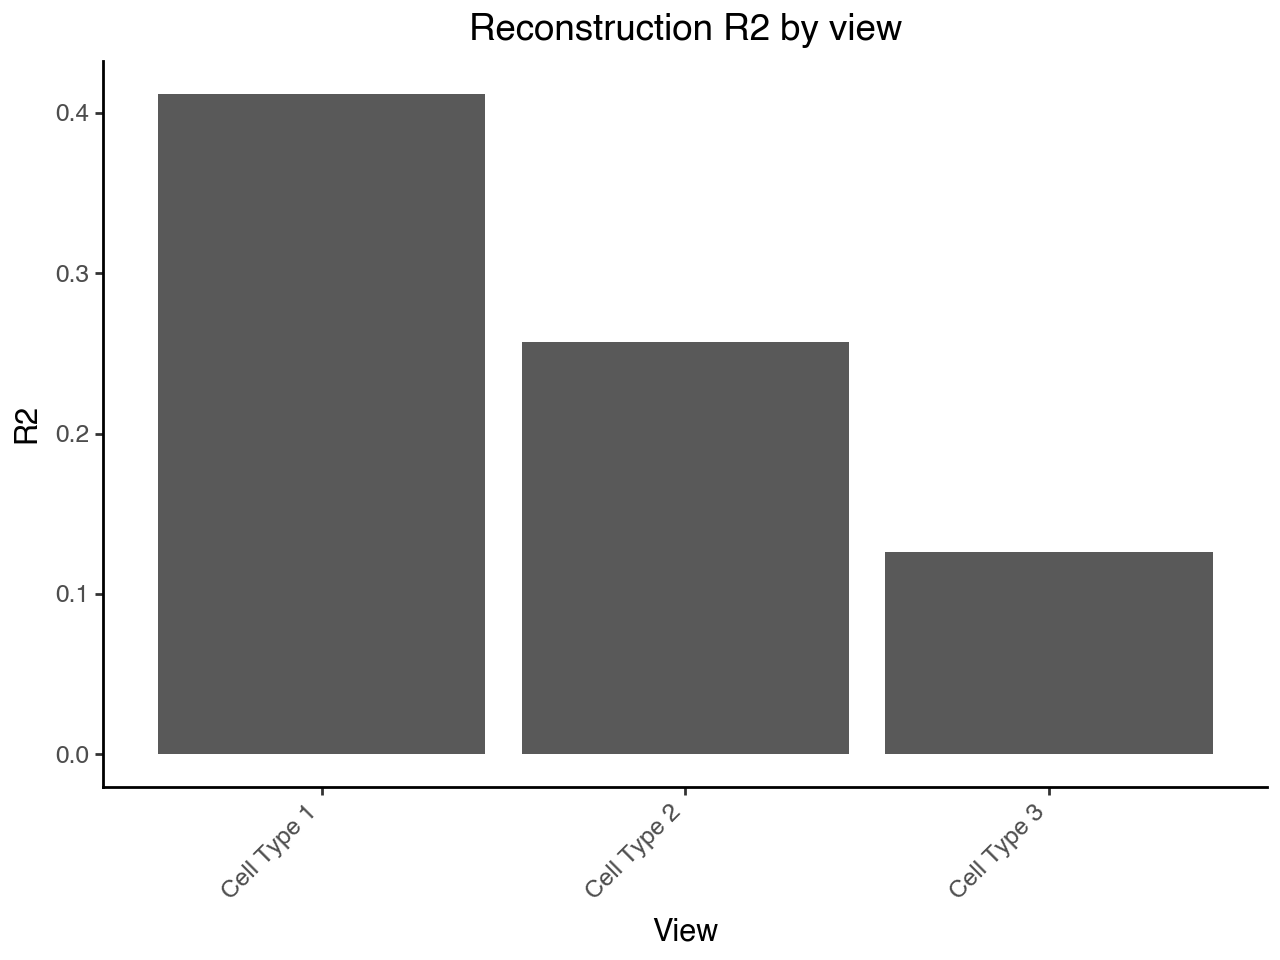

In [15]:
# 1) Reconstruction R2 per view
recon = muvi_reconstruction_info(model, mdata_processed, verbosity=1)
p1 = muvi_reconstruction_plot(recon["by_view"], title="Reconstruction R2 by view")
p1.show()

2025-09-23 18:24:30,607 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


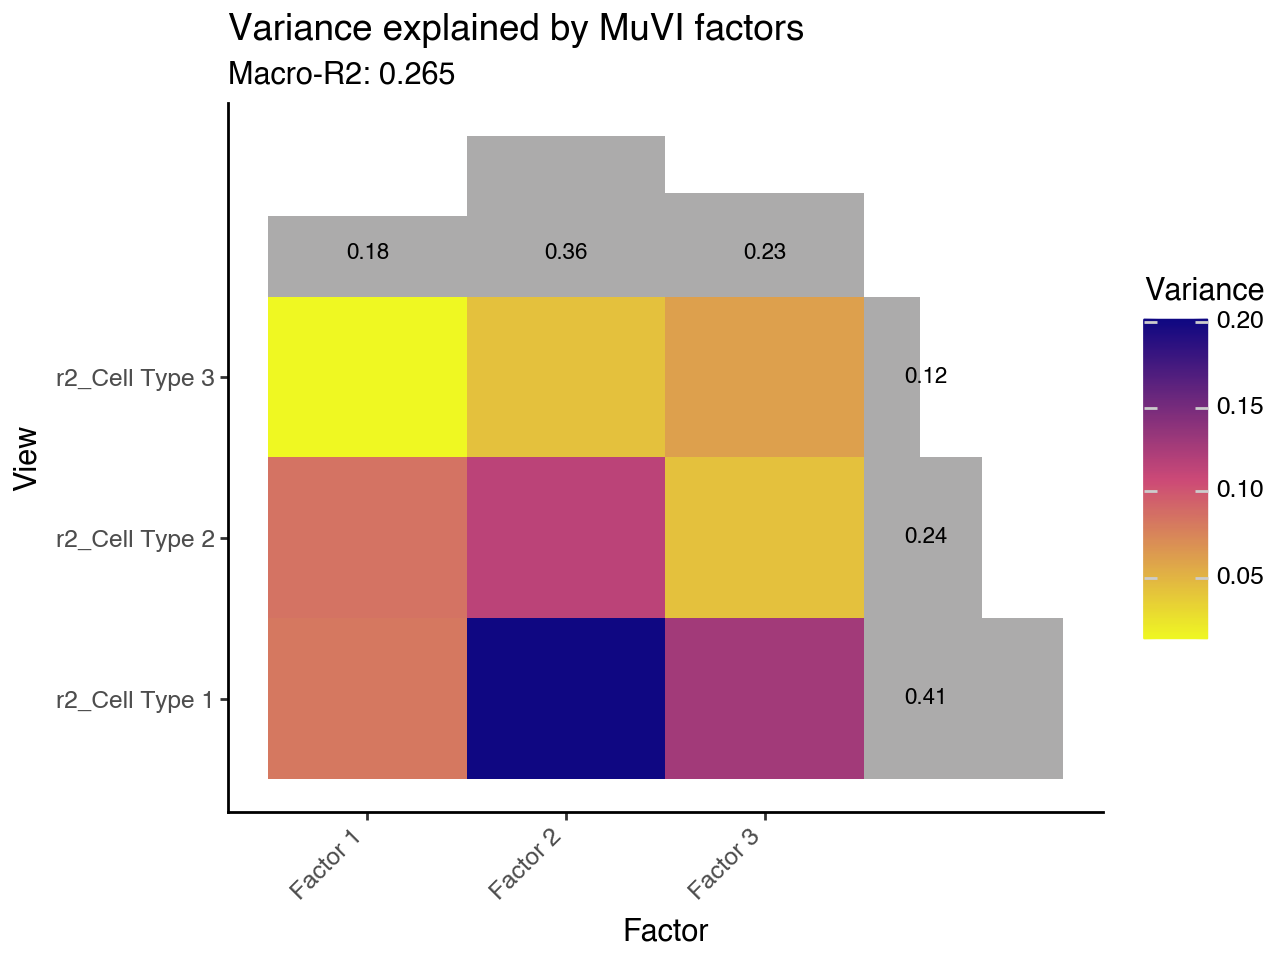

In [16]:
# 2) Variance explained by factors per view with marginal sums
v_by_view = muvi_variance_by_view_info(model, verbosity=0)
p2 = muvi_variance_by_view_plot(v_by_view, subtitle=f"Macro-R2: {np.round(recon['macro']['R2'], 3)}")
p2.show()

  Factor Feature_type  Variance
Factor 2    Pathway 1  0.068721
Factor 3    Pathway 1  0.050376
Factor 1    Pathway 1  0.065051
Factor 2    Pathway 2  0.128916
Factor 3    Pathway 2  0.139876


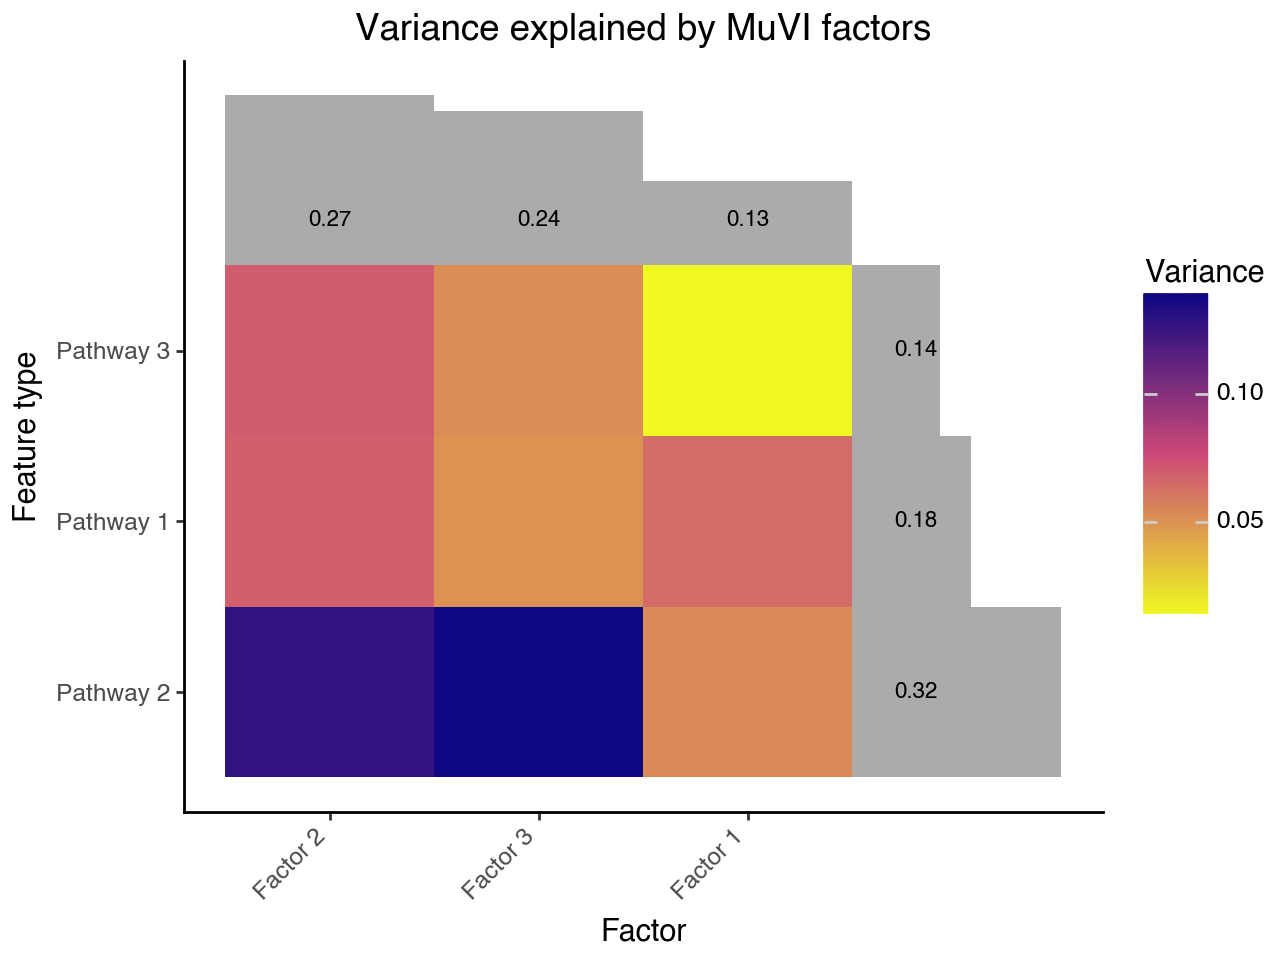

In [17]:
# 3) Feature class vs factor variance explained
# Example feature classes
all_vars = mdata_processed.var_names.tolist()

feature_type_map = {
    "Pathway 1": [v for v in all_vars if any(f"ft_{i}" in v for i in [0, 1, 2])],
    "Pathway 2": [v for v in all_vars if any(f"ft_{i}" in v for i in [3, 4])],
    "Pathway 3": [v for v in all_vars if not any(f"ft_{i}" in v for i in range(5))]
}

# Run analysis
v_by_class = muvi_featureclass_variance_info(
    model,
    mdata_processed,
    feature_type_map=feature_type_map,
    aggregator="median",
    verbosity=1
)

# Plot
p3 = muvi_featureclass_variance_plot(v_by_class)
p3.show()

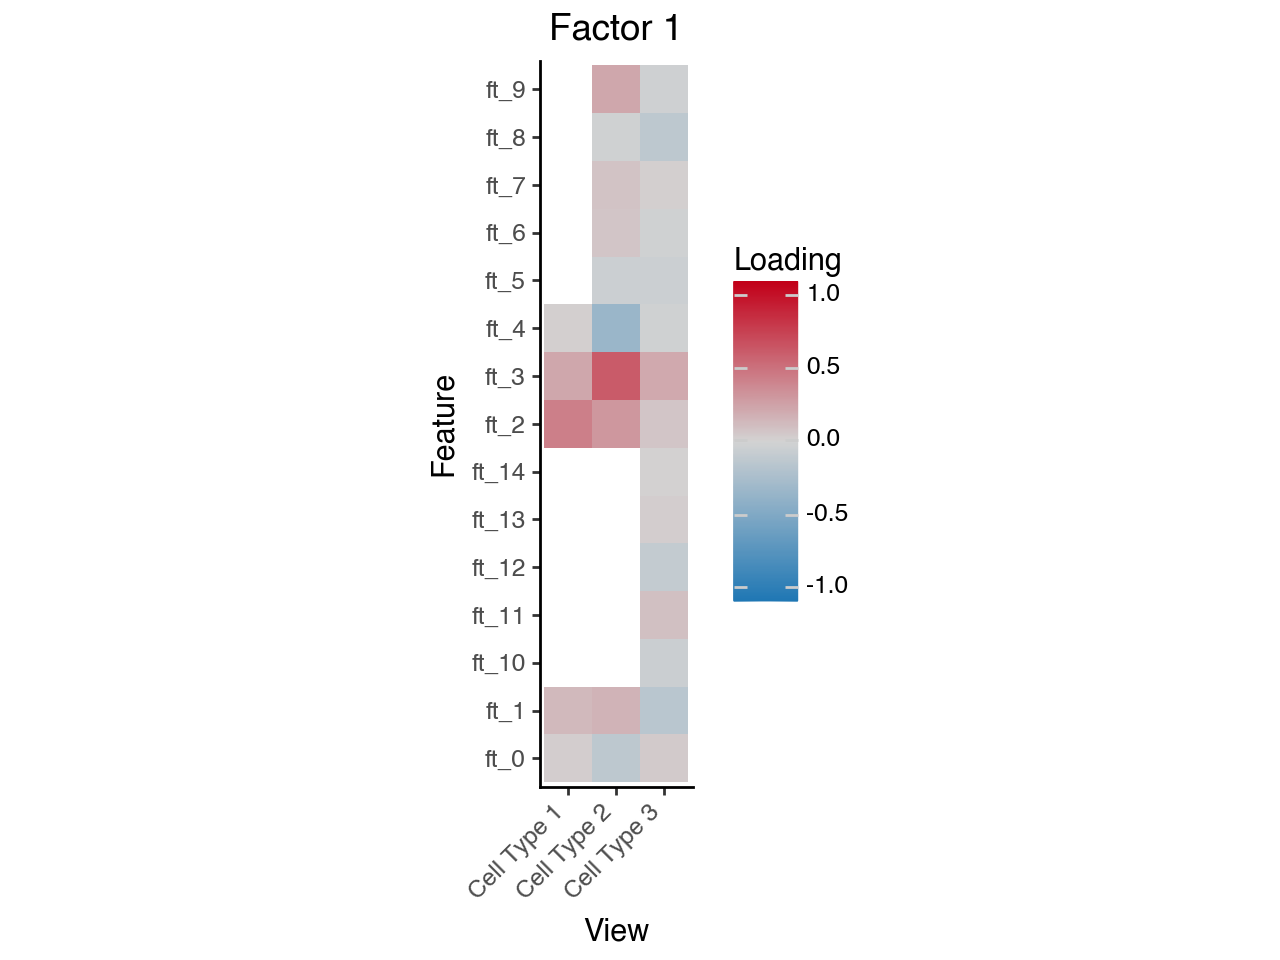

In [18]:
# 4) Variable loadings and top features for a factor
var_load = muvi_variable_loadings_info(model, mdata_processed, verbosity=0)
p4 = muvi_plot_top_loadings_heatmap(var_load, factor="Factor 1", top_n=30)
p4.show()

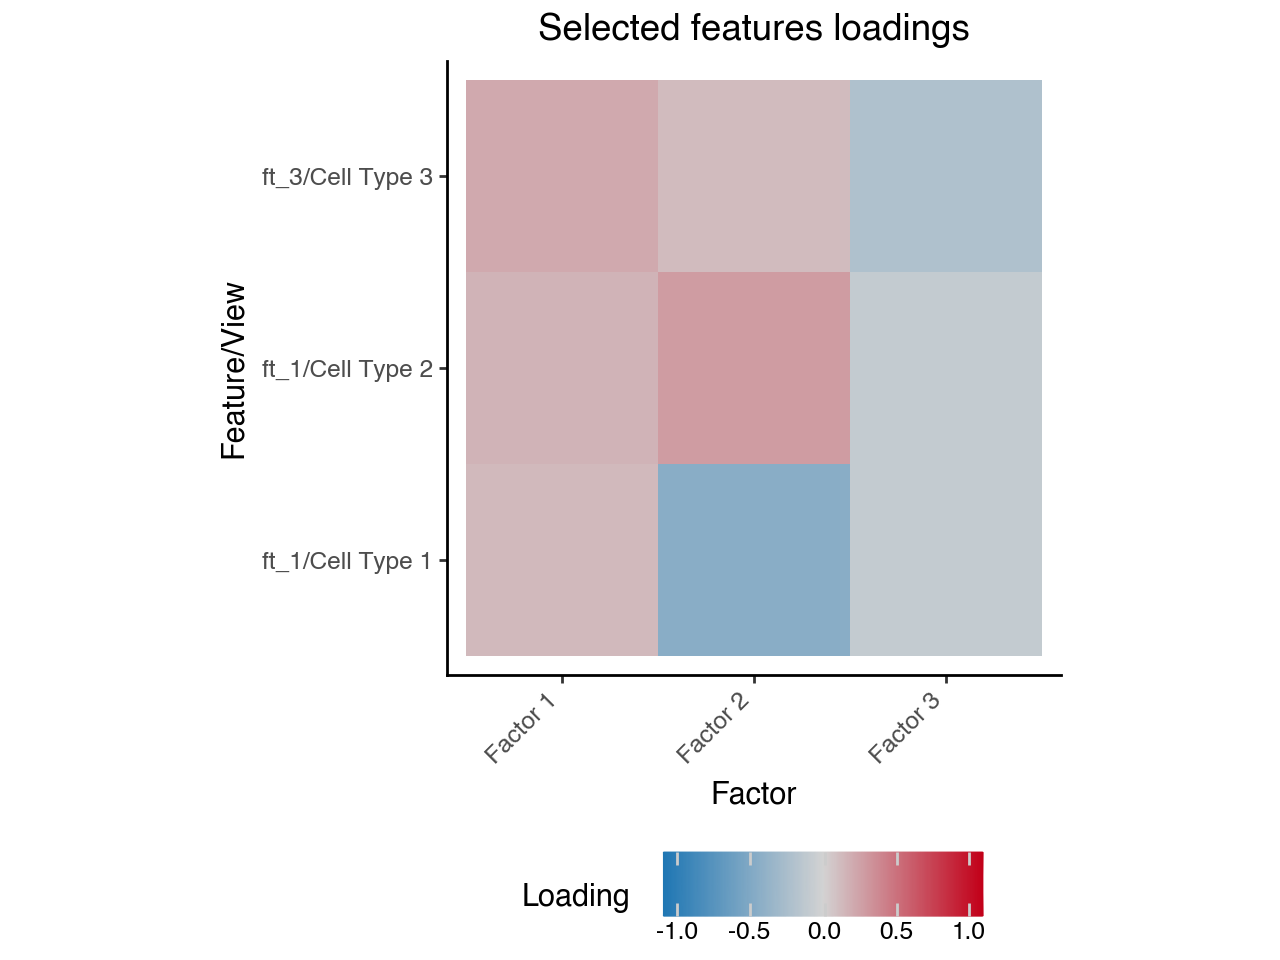

In [19]:
# 5) Selected features across factors
picked = [("ft_1", "Cell Type 1"), 
          ("ft_1", "Cell Type 2"),
          ("ft_3", "Cell Type 3"),]
picked_long = muvi_selected_features_info(var_load, picked, verbosity=0)
p5 = muvi_selected_features_plot(picked_long)
p5.show()

Kruskal-Wallis test for Cell Type 1:batch
  Factor   pvalue
Factor 2 0.099484
Factor 1 1.000000
Factor 3 1.000000
Kendall tau test for Cell Type 1:batch
  Factor   pvalue
Factor 2 0.099484
Factor 1 1.000000
Factor 3 1.000000


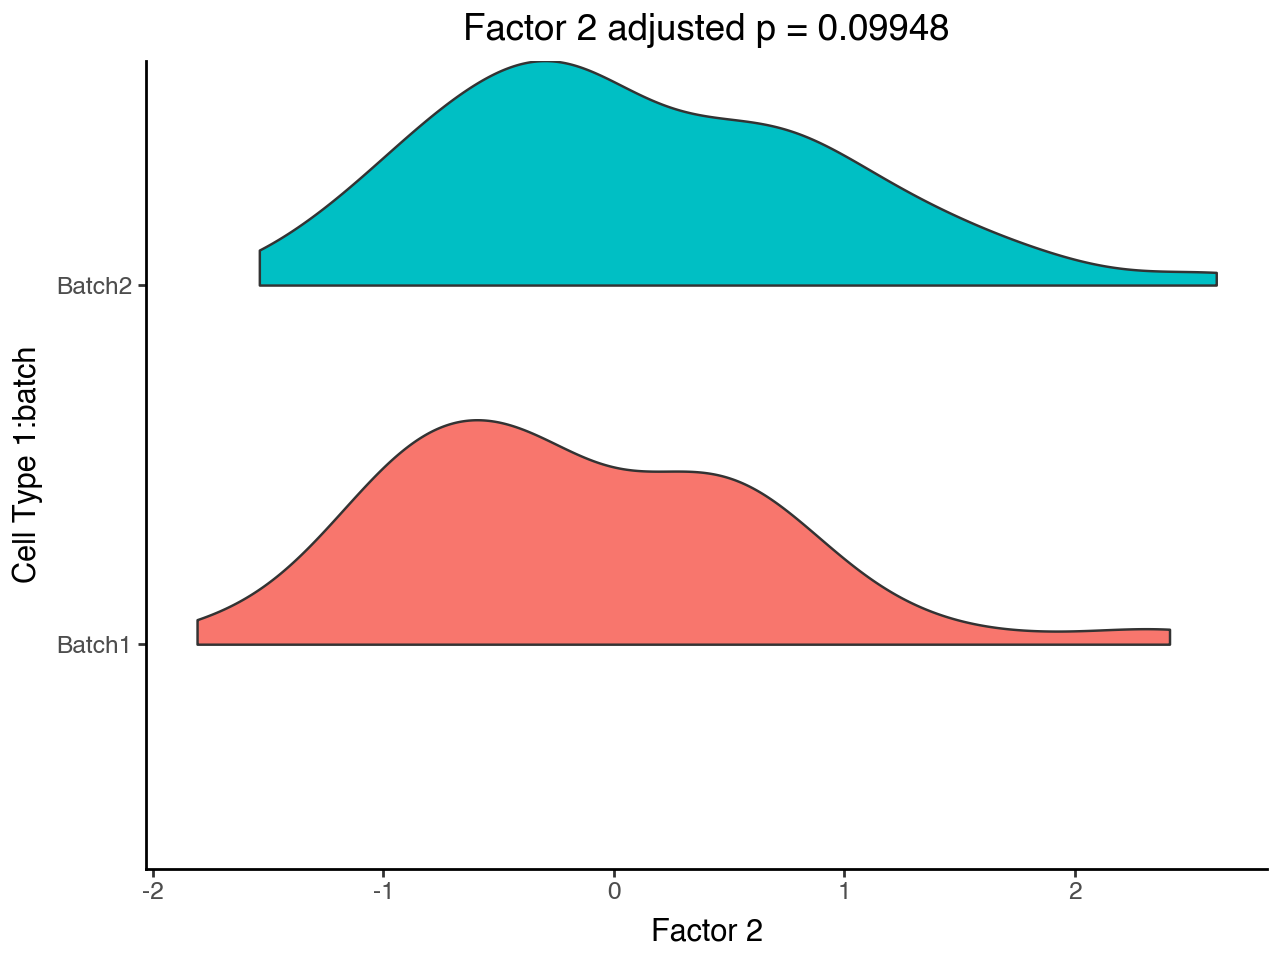

Kruskal-Wallis test for exposure
  Factor       pvalue
Factor 2 7.692064e-07
Factor 1 7.720219e-02
Factor 3 1.000000e+00
Kendall tau test for exposure
  Factor       pvalue
Factor 2 6.118379e-08
Factor 1 1.883532e-02
Factor 3 1.000000e+00


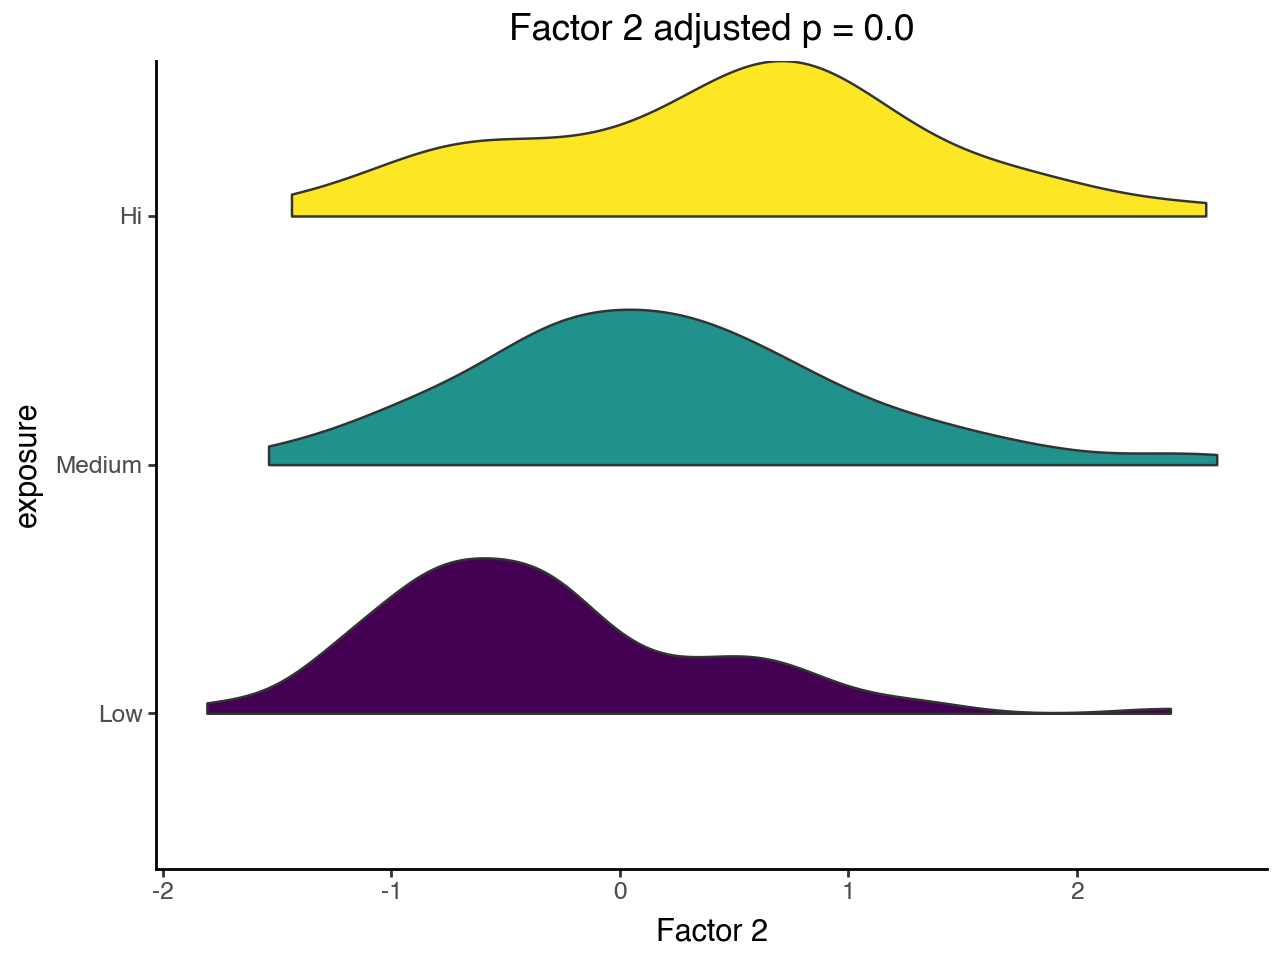

In [20]:
# 6) Scores with clinical covariates and tests
clin_variables = ["Cell Type 1:batch", "exposure"]
scores = muvi_factor_scores_info(model, mdata_processed, obs_keys=clin_variables, verbosity=0)

for var in clin_variables:
    print(f"Kruskal-Wallis test for {var}")
    kw = muvi_kruskal_info(scores, group_col=var, verbosity=1)
    print(f"Kendall tau test for {var}") # For ordinal variables
    muvi_kendall_info(scores, ordinal_col=var, verbosity=1)
    p6 = muvi_violin_plot(scores, factor="Factor 2", group_col=var, pvalue=float(kw[kw.Factor=="Factor 2"]["pvalue"]))
    p6.show()

        x        y exposure
-1.634485 0.717296   Medium
-1.662905 0.617261   Medium
-1.684427 0.515448   Medium
-1.698964 0.412266   Medium
-1.706458 0.308131   Medium


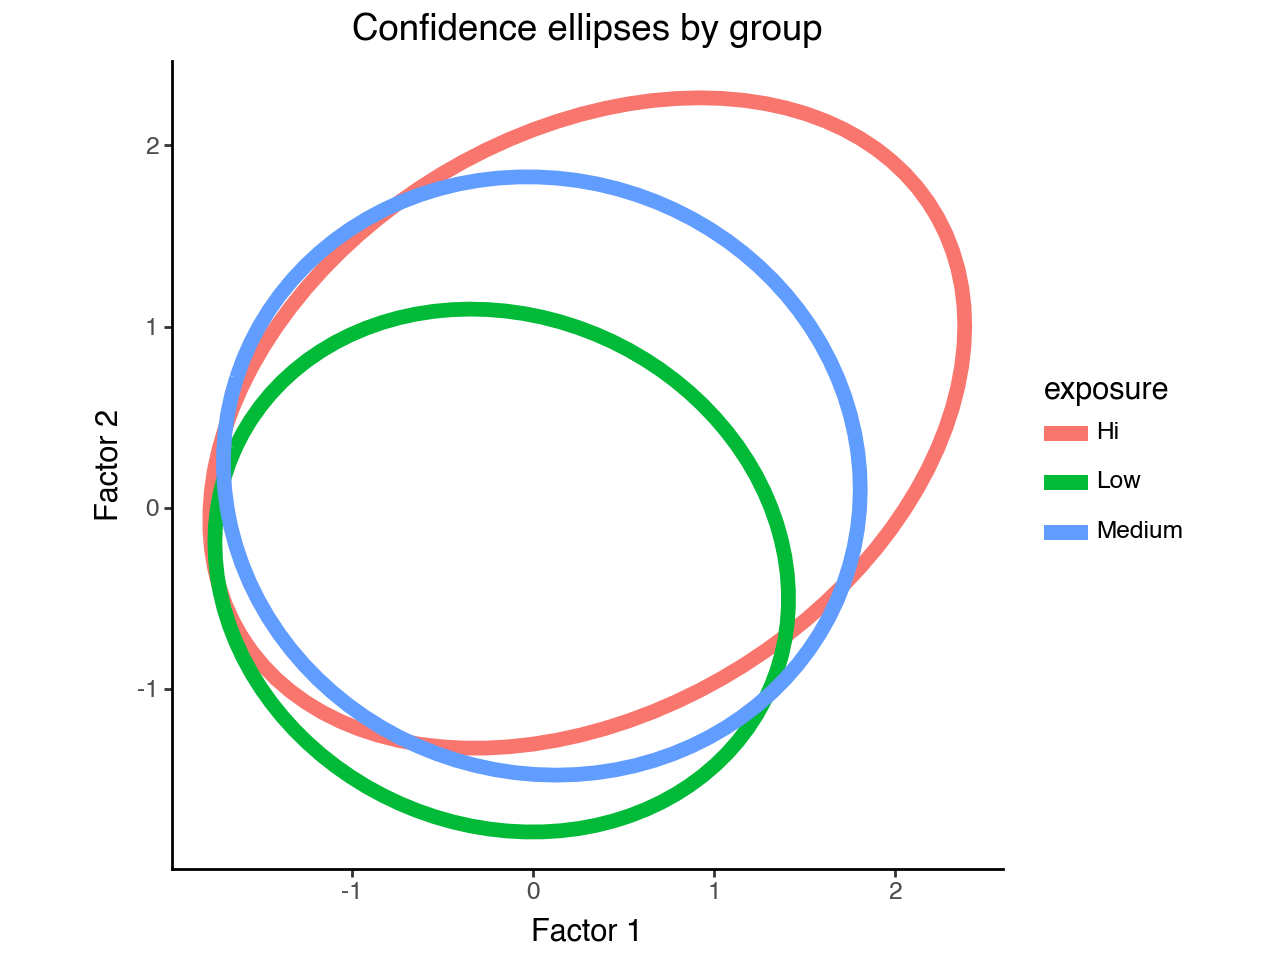

In [21]:
# 7) Confidence ellipses for two factors by 
ell = muvi_confidence_ellipses_info(scores, x_factor="Factor 1", y_factor="Factor 2", group_col="exposure", 
                                    nstd=2, verbosity=1)
p7 = muvi_confidence_ellipses_plot(scores, ell, x_factor="Factor 1", y_factor="Factor 2", group_col="exposure")
p7.show()

In [22]:
# 8) Export top features
top_by_view = muvi_top_features_by_view_info(var_load, factors=["Factor 1", "Factor 2"], 
                                             top_per_view=2, verbosity=0)
top_ad = muvi_build_selected_anndata(mdata_processed, top_by_view.rename(columns={"View": "View"}))
top_ad.write("top_features_multi_pT.h5ad")
top_by_view.to_csv("top_features_multi_pT.csv", index=False)

... storing 'batch' as categorical
... storing 'Variable' as categorical
... storing 'View' as categorical
... storing 'Factor' as categorical
